In [1]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams

In [2]:
data = pd.read_excel("CocaCola_Sales_Rawdata.xlsx")
data.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [3]:
data.shape

(42, 2)

In [4]:
data.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [5]:
data['Quarters']= 0
data['Year'] = 0
for i in range(42):
    p = data["Quarter"][i]
    data['Quarters'][i]= p[0:2]
    data['Year'][i]= p[3:5]

<ipython-input-5-71bede3346bd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Quarters'][i]= p[0:2]
C:\python-install1\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-5-71bede3346bd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Year'][i]= p[3:5]


In [6]:
# Prepring dummies 
Quarters_Dummies = pd.DataFrame(pd.get_dummies(data['Quarters']))
df = pd.concat([data,Quarters_Dummies],axis = 1)

In [7]:
df.head()

,Quarter,Sales,Quarters,Year,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1,86,1,0,0,0
1,Q2_86,2244.960999,Q2,86,0,1,0,0
2,Q3_86,2533.804993,Q3,86,0,0,1,0
3,Q4_86,2154.962997,Q4,86,0,0,0,1
4,Q1_87,1547.818996,Q1,87,1,0,0,0


In [8]:
df.head()

,Quarter,Sales,Quarters,Year,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1,86,1,0,0,0
1,Q2_86,2244.960999,Q2,86,0,1,0,0
2,Q3_86,2533.804993,Q3,86,0,0,1,0
3,Q4_86,2154.962997,Q4,86,0,0,0,1
4,Q1_87,1547.818996,Q1,87,1,0,0,0


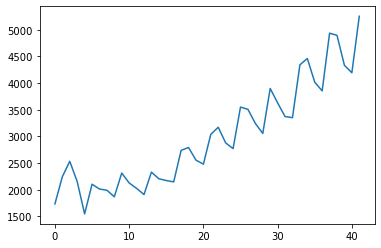

In [9]:
df.Sales.plot()

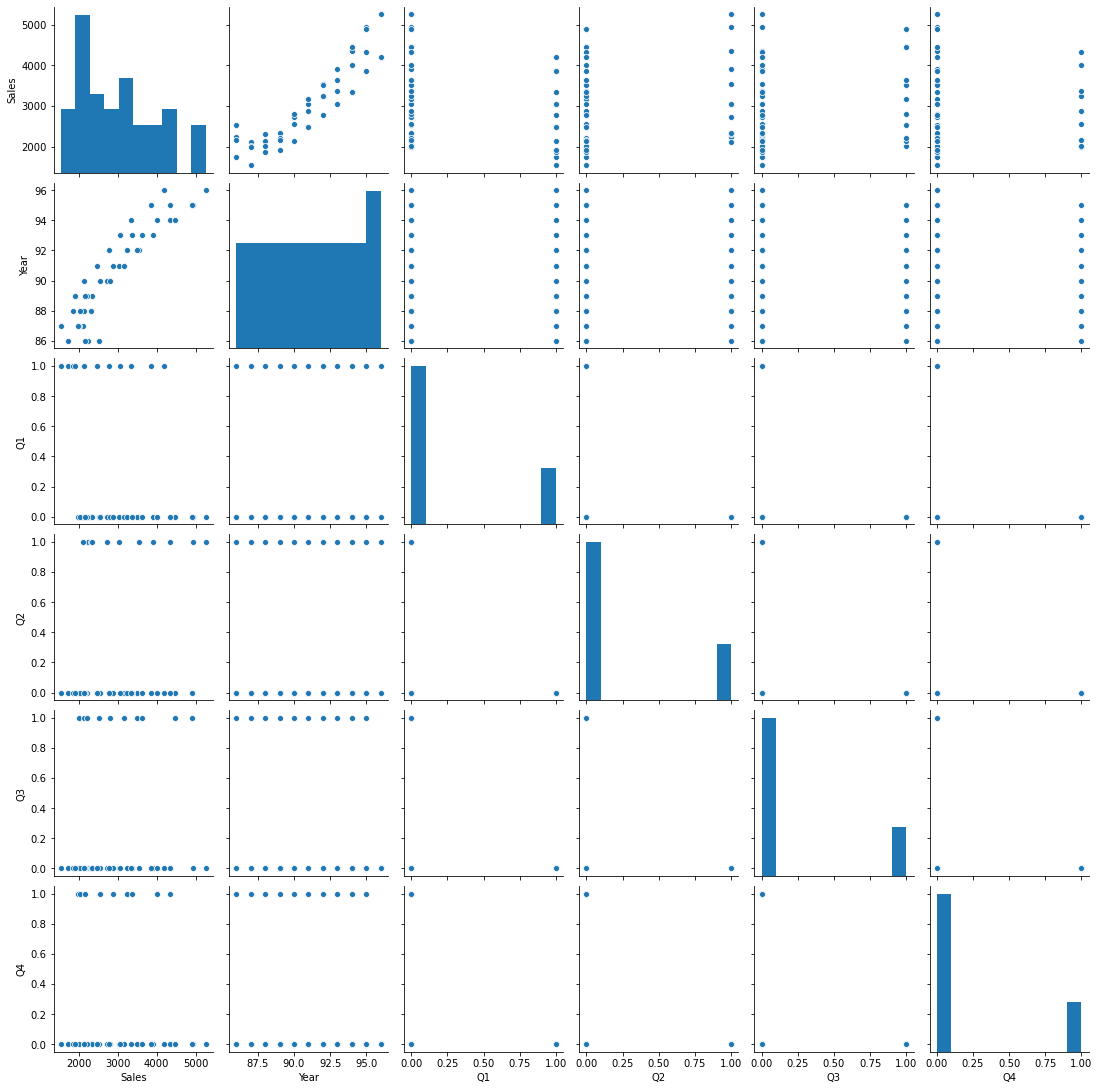

In [10]:
import seaborn as sns
sns.pairplot(df)

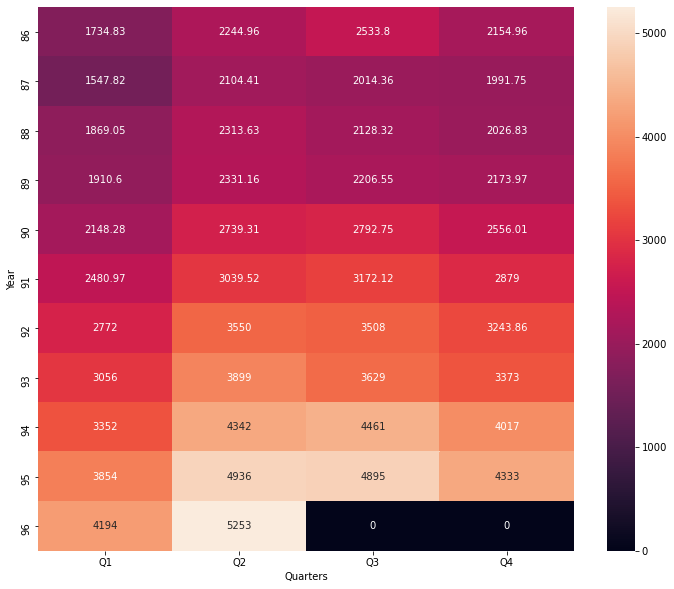

In [11]:
# visualize the data

plt.figure(figsize=(12,10))
plot_month_y = pd.pivot_table(data = df,values="Sales",index="Year",columns="Quarters"
                             ,aggfunc="mean",fill_value=0)
sns.heatmap(plot_month_y,annot=True,fmt = "g")

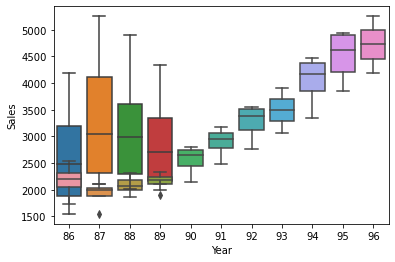

In [12]:
sns.boxplot(x="Quarters",y="Sales",data=df)
sns.boxplot(x="Year",y="Sales",data=df)

In [13]:
df["t"]=np.arange(1,43)

In [14]:
df["t_squared"] = df["t"]*df["t"]
df.columns

Index(['Quarter', 'Sales', 'Quarters', 'Year', 'Q1', 'Q2', 'Q3', 'Q4', 't',
       't_squared'],
      dtype='object')

In [15]:
df["Log_Sales"]=np.log(df["Sales"])

In [16]:
Train = df.head(38)
Test = df.tail(4)

In [17]:
# Linear model
import statsmodels.formula.api as smf
linear_model = smf.ols('Sales~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_linear))**2))
rmse_linear

591.5532957223963

In [18]:
# Exponential
Exp = smf.ols('Log_Sales~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

466.24797310672346

In [27]:
# Quadratic
Quad = smf.ols('Sales~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_Quad))**2))
rmse_Quad

475.56183518315095

In [28]:
# Additive seasonality
add_sea = smf.ols('Sales~Q1+Q2+Q3',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Q1','Q2','Q3']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1860.0238154547276

In [29]:
# Additive Seasonality Quadratic
add_sea_Quad = smf.ols('Sales~t+t_squared+Q1+Q2+Q3',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Q1','Q2','Q3','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad 

301.7380071934617

In [30]:

# Multiplicative Seasonality
Mul_sea = smf.ols('Log_Sales~Q1+Q2+Q3',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea


1963.389640077973

In [31]:
# Multiplicative Additive Seasonality
Mul_Add_sea = smf.ols('Log_Sales~t+Q1+Q2+Q3',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

225.52439049818733

In [96]:

#tabulating the rmse values

data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse



,MODEL,RMSE_Values
0,rmse_linear,591.553296
1,rmse_Exp,466.247973
2,rmse_Quad,475.561835
3,rmse_add_sea,1860.023815
4,rmse_add_sea_quad,301.738007
5,rmse_Mult_sea,1963.389640
6,rmse_Mult_add_sea,225.524390


In [97]:
#predict with the new data
df_new = pd.read_excel("cocacola_new.xlsx")

In [98]:
model_ = smf.ols('Sales~t',data=df).fit()
model_pred =pd.Series(model_.predict(df_new))
model_pred

0     4569.833196
1     4643.111331
2     4716.389465
3     4789.667600
4     4862.945734
5     4936.223868
6     5009.502003
7     5082.780137
8     5156.058271
9     5229.336406
10    5302.614540
dtype: float64

In [99]:
df_new["forecasted_Sales"] = pd.Series(model_pred)
df_new

,Quarter,t,t_square,forecasted_Sales
0,Q3_96,43,1849,4569.833196
1,Q4_96,44,1936,4643.111331
2,Q1_97,45,2025,4716.389465
3,Q2_97,46,2116,4789.667600
4,Q3_97,47,2209,4862.945734
5,Q3_96,48,2304,4936.223868
6,Q4_96,49,2401,5009.502003
7,Q1_98,50,2500,5082.780137
8,Q2_98,51,2601,5156.058271
9,Q3_98,52,2704,5229.336406


## 225.52439049818733  
## multiplicative additive seasonality is best model